In [1]:
# import attack_kernelbased
import attack_fgsm_dnn
import attack_df_dnn
# import attack_jsma
import attack_gen_dnn
import dataloader
import spatial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm

In [2]:
device = 'cpu'

In [3]:
X_train, X_test, y_train, y_test = dataloader.load(None, sklearn_dataset_name='Fashion-MNIST')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

/Users/sang-geon/Documents/UCI_BIASLab/kernel_adversarial/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(torch.Size([52500, 784]),
 torch.Size([17500, 784]),
 torch.Size([52500]),
 torch.Size([17500]))

In [4]:
X_test = X_test[:1000]
y_test = y_test[:1000]

## CNN

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.307111  [    0/52500]
loss: 1.128055  [ 6400/52500]
loss: 0.703308  [12800/52500]
loss: 0.685835  [19200/52500]
loss: 0.580651  [25600/52500]
loss: 0.516777  [32000/52500]
loss: 0.599462  [38400/52500]
loss: 0.536582  [44800/52500]
loss: 0.689938  [51200/52500]
Epoch 2
-------------------------------
loss: 0.472085  [    0/52500]
loss: 0.562481  [ 6400/52500]
loss: 0.697899  [12800/52500]
loss: 0.775677  [19200/52500]
loss: 0.506201  [25600/52500]
loss: 0.417465  [32000/52500]
loss: 0.500575  [38400/52500]
loss: 0.648799  [44800/52500]
loss: 0.511809  [51200/52500]
Epo

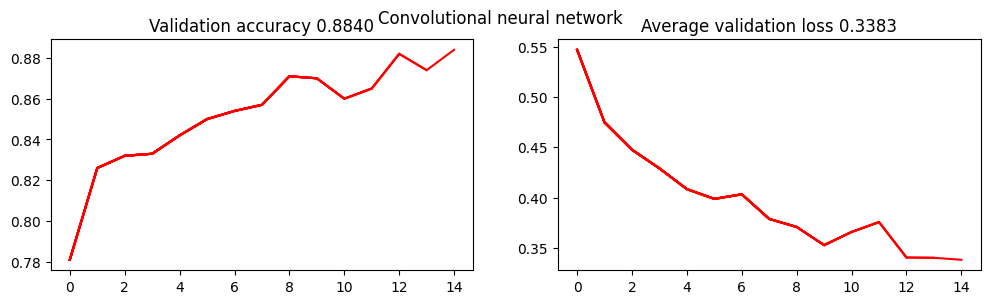

In [5]:
BATCH_SIZE = 64
EPOCHS = 15

training_data = DNNmodels.CustomImageDataset(X_train, y_train, model_type='cnn')
val_data = DNNmodels.CustomImageDataset(X_test, y_test, model_type='cnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model_cnn = DNNmodels.CNN().to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = DNNmodels.EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Convolutional neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    DNNmodels.train(train_dataloader, model_cnn, loss_fn, optimizer)
    DNNmodels.test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    DNNmodels.plot_results(axs, result)

In [6]:
torch.save(model_cnn.state_dict(), './model_cnn_fmnist.pt')

In [7]:
model_cnn = DNNmodels.CNN()
model_cnn.load_state_dict(torch.load('./model_cnn_fmnist.pt'))
model_cnn.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
with open('./onlinehd_fmnist.pickle', 'br') as f:
    model_onlinehd = pickle.load(f)

### FGSM

100%|██████████| 1000/1000 [00:02<00:00, 432.20it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 2.430076165999992 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 81.50%
mean of norm=0.010000000707805157


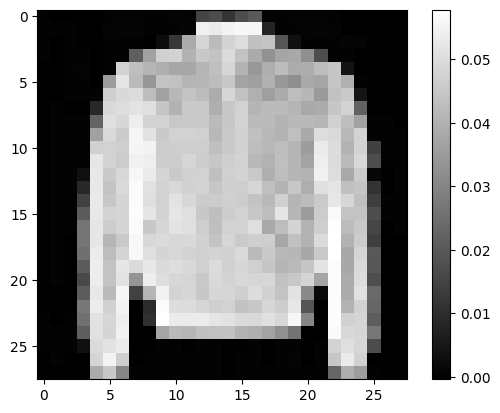

100%|██████████| 1000/1000 [00:02<00:00, 418.85it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 2.3963307079999936 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 75.60%
mean of norm=0.020000003278255463


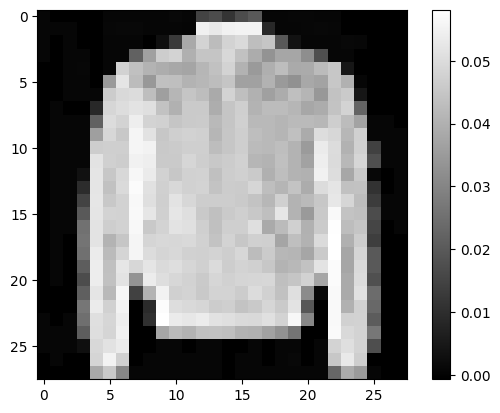

100%|██████████| 1000/1000 [00:02<00:00, 422.82it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 2.372287333000031 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 68.40%
mean of norm=0.029999999329447746


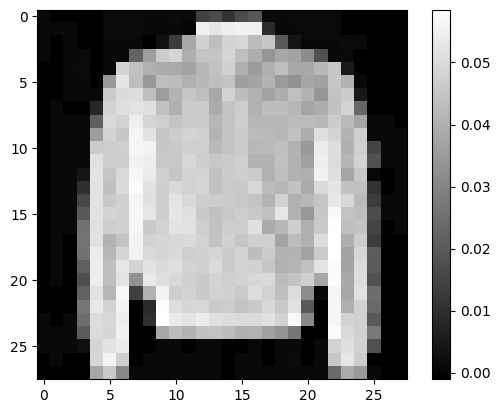

100%|██████████| 1000/1000 [00:02<00:00, 368.52it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 2.728859875000012 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 60.30%
mean of norm=0.03999999910593033


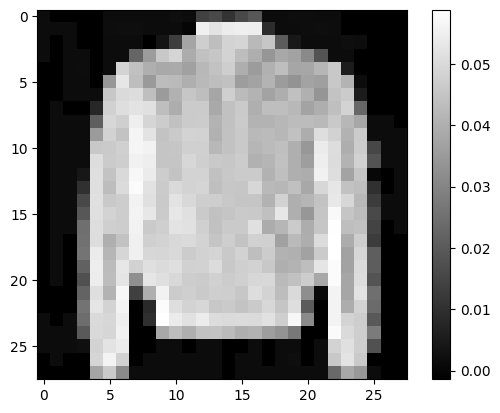

100%|██████████| 1000/1000 [00:02<00:00, 383.90it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 2.6138187920000178 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 54.10%
mean of norm=0.05000000447034836


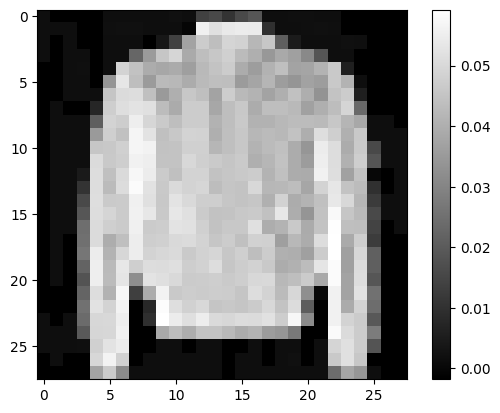

100%|██████████| 1000/1000 [00:02<00:00, 448.92it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 2.240814250000028 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 47.70%
mean of norm=0.05999999865889549


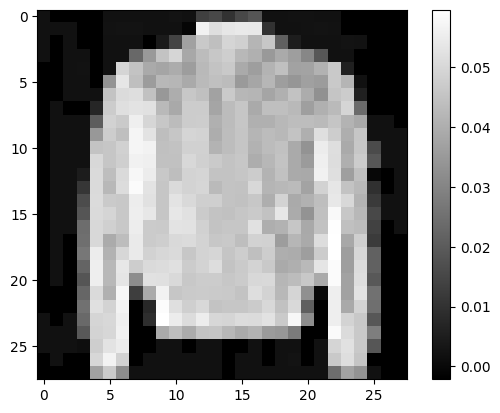

100%|██████████| 1000/1000 [00:02<00:00, 452.64it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 2.2195255419999853 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 40.40%
mean of norm=0.07000000029802322


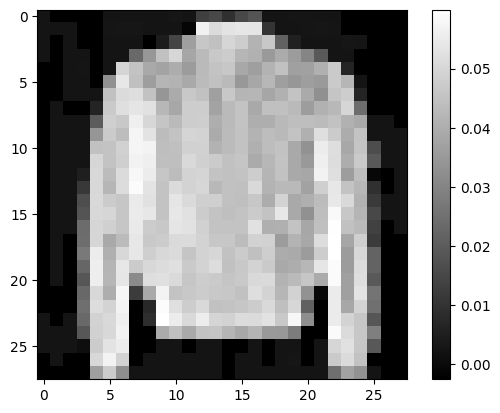

100%|██████████| 1000/1000 [00:02<00:00, 486.52it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 2.0672738330000016 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 33.70%
mean of norm=0.07999999821186066


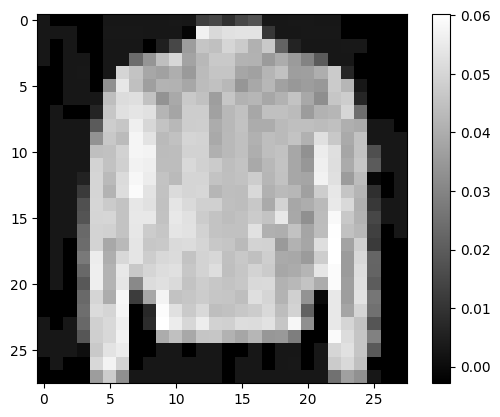

100%|██████████| 1000/1000 [00:02<00:00, 447.81it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 2.2408922500000017 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 27.60%
mean of norm=0.09000000357627869


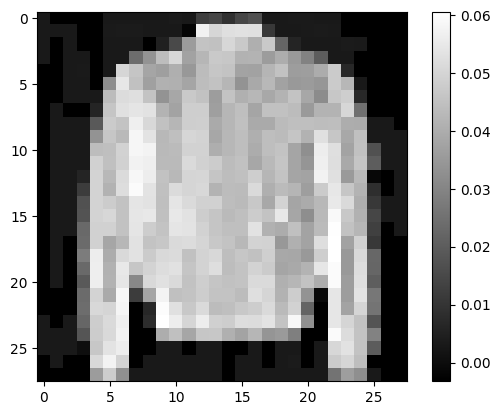

100%|██████████| 1000/1000 [00:02<00:00, 444.73it/s]



FGSM Attack with epsilon = 0.10000 | Elapsed time: 2.25578900000005 seconds.
Accuracy: Before the attack -> 88.40%	|	After the attack -> 22.60%
mean of norm=0.10000000149011612


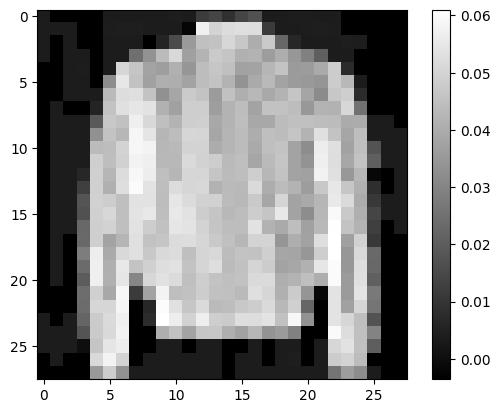

In [9]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
criterion = nn.CrossEntropyLoss()
#criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm_dnn.attack(
    model_cnn, X_train.reshape(len(X_train), 28, 28), X_test.reshape(len(X_test), 28, 28), y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu')

In [10]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

0.01 0.010000000707805157 0.8040000200271606 0.8149999976158142
0.020000000000000004 0.020000003278255463 0.7979999780654907 0.7559999823570251
0.030000000000000006 0.029999999329447746 0.7850000262260437 0.6840000152587891
0.04000000000000001 0.03999999910593033 0.7680000066757202 0.6029999852180481
0.05000000000000001 0.05000000447034836 0.7570000290870667 0.5410000085830688
0.06000000000000001 0.05999999865889549 0.7440000176429749 0.47699999809265137
0.07 0.07000000029802322 0.734000027179718 0.40400001406669617
0.08 0.07999999821186066 0.7160000205039978 0.3370000123977661
0.09000000000000001 0.09000000357627869 0.699999988079071 0.2759999930858612
0.1 0.10000000149011612 0.6840000152587891 0.22599999606609344


### Deep Fool

In [11]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, 28, 28)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, 28, 28), model_cnn, epsilon=max_update)
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]


107.86359596252441
0.01 0.009164322167634964 0.8069999814033508 0.843999981880188


100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


89.03927803039551
0.02 0.018306247889995575 0.7960000038146973 0.7459999918937683


100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


73.79533791542053
0.03 0.02745937369763851 0.7889999747276306 0.6389999985694885


100%|██████████| 1000/1000 [01:08<00:00, 14.62it/s]


68.4097888469696
0.04 0.03661249577999115 0.7820000052452087 0.5400000214576721


100%|██████████| 1000/1000 [00:58<00:00, 16.99it/s]


58.84271693229675
0.05 0.045765627175569534 0.7770000100135803 0.4300000071525574


100%|██████████| 1000/1000 [00:46<00:00, 21.38it/s]


46.77393698692322
0.060000000000000005 0.05491874739527702 0.7620000243186951 0.3330000042915344


100%|██████████| 1000/1000 [00:37<00:00, 26.92it/s]


37.15031886100769
0.06999999999999999 0.06407187134027481 0.7429999709129333 0.25999999046325684


100%|██████████| 1000/1000 [00:31<00:00, 31.93it/s]


31.318943977355957
0.08 0.0732249915599823 0.7250000238418579 0.2150000035762787


100%|██████████| 1000/1000 [00:27<00:00, 36.69it/s]


27.255468130111694
0.09 0.08237812668085098 0.7120000123977661 0.18000000715255737


100%|██████████| 1000/1000 [00:24<00:00, 41.42it/s]


24.146033763885498
0.09999999999999999 0.09153125435113907 0.6959999799728394 0.15399999916553497


100%|██████████| 1000/1000 [00:21<00:00, 45.64it/s]


21.915646076202393
0.11 0.10068437457084656 0.6790000200271606 0.13699999451637268


100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


20.833616256713867
0.12 0.10983749479055405 0.6620000004768372 0.12700000405311584


100%|██████████| 1000/1000 [00:19<00:00, 51.26it/s]


19.512345790863037
0.13 0.11899061501026154 0.6460000276565552 0.11999999731779099


100%|██████████| 1000/1000 [00:19<00:00, 51.31it/s]


19.49229097366333
0.14 0.12814374268054962 0.6309999823570251 0.11599999666213989


100%|██████████| 1000/1000 [00:18<00:00, 54.91it/s]


18.214761972427368
0.15000000000000002 0.1372968703508377 0.6169999837875366 0.11299999803304672


100%|██████████| 1000/1000 [00:18<00:00, 55.34it/s]


18.07297682762146
0.16 0.1464499831199646 0.6000000238418579 0.11299999803304672


100%|██████████| 1000/1000 [00:18<00:00, 53.92it/s]


18.547280073165894
0.17 0.15560312569141388 0.5820000171661377 0.11299999803304672


100%|██████████| 1000/1000 [00:18<00:00, 53.37it/s]


18.739684104919434
0.18000000000000002 0.16475625336170197 0.5690000057220459 0.11299999803304672


100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s]


18.636570930480957
0.19 0.17390938103199005 0.5569999814033508 0.11299999803304672


100%|██████████| 1000/1000 [00:18<00:00, 53.08it/s]


18.84188985824585
0.2 0.18306250870227814 0.5460000038146973 0.11299999803304672


In [12]:
X_te_cln = X_test.clone().reshape(-1, 1, 28, 28)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

st = time.time()
for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, 28, 28), model_cnn, epsilon=None)
print(time.time() - st)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 1000/1000 [00:18<00:00, 54.28it/s]


18.427114248275757
None 0.08917317539453506 0.7239999771118164 0.11400000005960464


### Genetic Attack

In [13]:
alpha_lis = np.linspace(0.0004, 0.0037, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0004


100%|██████████| 1000/1000 [42:18<00:00,  2.54s/it]


2538.3901069164276
0.0004 0.012574045918881893 0.8140000104904175 0.8730000257492065
Alpha : 0.0005736842105263159


100%|██████████| 1000/1000 [45:21<00:00,  2.72s/it]


2721.9357857704163
0.0005736842105263159 0.017964759841561317 0.8119999766349792 0.8659999966621399
Alpha : 0.0007473684210526316


100%|██████████| 1000/1000 [44:03<00:00,  2.64s/it]


2643.4771349430084
0.0007473684210526316 0.023124177008867264 0.8059999942779541 0.8610000014305115
Alpha : 0.0009210526315789475


 11%|█         | 108/1000 [04:46<39:26,  2.65s/it]

: 

: 